# 풀이 전략

====== 모델 흐름 ======  
(1) 글자 개수가 몇개인지 판단하는 모델 하나  
(2) 각 글자를 자르는 툴 하나  
(3) 각 글자가 무엇인지 판단하는 모델 하나  
(4) 각 글자를 이어서 단어를 만드는 툴 하나  

====== 필요 툴 ======
* 글자인지 여백인지 판단하는 툴 : 열이 모두 0이면 여백 (마 등 여백이 포함된 글자는 주의)  
* 각 글자를 자르는 툴  
* 밑단 기준으로 평행을 맞추는 툴 : 한 글자에 값이 있는 셀 중 가장 밑단 인식 -> 후 다른 글자와 밑단이 맞게끔 당김  
* 각 글자를 이어 단어를 만드는 툴  

====== overview 파일 ======
* 이미지 경로  
* 레이블  
* 글자수  


## 정확도 높이기

(1) 글자 섞기  
- 원래 있는 글자들을 이어서 새로운 데이터처럼 만들기  
- 당연히 label 도 이어야 하고  
- 데이터 늘어남에 따라 학습수 많아짐  
  
(2-1) 흐린 글자 명확하게 만들기 - 제곱  
- 흐린 글자 명료도 높이는 방법 확인  
- 각 픽셀의 채널값을 제곱화하면 -> 낮은 수는 낮고, 높은 수는 상대적으로 상승폭이 늘어날 것.  
- 그러면 명료도가 올라가겠지!  
- 제곱 후 특정 수로 나눠주고, 최대값 제한하여 다시 한 번 처리하기  
- 특정 값 이하인 경우에서는 자동으로 실행하도록 해야 할 듯.  
  
(2-2) 흐린 글자 명확하게 만들기 - PIL 패키지  
- PIL 패키지 내 contour 메서드  
- PIL 패키지 내 Sharpen 메서드  

(3) 노이즈가 존재하는 이미지  
- 노이즈는 색깔이 있는 걸로 인식되어.. 위 단계 명확하게 만들기에서 오히려 악영향을 받을 수 있음  
- 반복되는 행렬의 흐름 (=노이즈)를 제거하는 방법 고민 필요  

(4) 기울어진 글자 존재  
- 기울어진 글자 -> 똑바로 조절 필요  
- PIL.transpose.rotate 존재. 하지만 기울어졌는지에 대한 인지와 평가 기준은?  

## 참고사항 / 읽을거리

(1) 대회 페이지 : https://dacon.io/competitions/official/236042/overview/description  
(2) PIL 패키지 : https://pillow.readthedocs.io/en/stable/reference/index.html  
(3) text generator : https://github.com/Belval/TextRecognitionDataGenerator  

(1) 한글 및 한국어 정보처리 학술대회 2019 : https://koreascience.kr/article/CFKO201930060791848.pdf  
(2) 한글 및 한국어 정보처리 학술대회 : http://www.hclt.kr/symp/?lnb=conference  

## 정리할 사항

In [ ]:
# (1) 문자열을 한 글자씩 자르기
# str = '안녕하세요'
# ls = list(str)
# ls 출력 : ['안', '녕', '하', '세', '요']

In [ ]:
# (2) 이미지 흑백전환 PIL 패키지 이용
# img = Image.read(path)
# img_gray = img.convert('L')
# 참고 : https://coding-kindergarten.tistory.com/159

## 오류

In [ ]:
# (1) PIL이미지
# 오류메세지 : Cannot handle this data type: (1, 1, 3), <f8
# 상황 : 이미지를 뚜렷하게 만들기 위해 ndarray를 float화 해준 후, 제곱. 이후 Image.fromarray()
# 원인 : PIL 패키지는 array안의 데이터의 타입이 uint8이어야 함
# 해결 : np.astype(uint8) 메서드를 이용해 해결
# 참고 : https://yjs-program.tistory.com/248

# Import

In [336]:
import pandas as pd
import numpy as np
import glob as glob
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn.preprocessing import MinMaxScaler

# Dataset

In [27]:
# train, test 데이터셋 선언

x_train = pd.DataFrame(pd.read_csv('train.csv')['img_path'])
x_test = pd.DataFrame(pd.read_csv('test.csv')['img_path'])
y_train = pd.DataFrame(pd.read_csv('train.csv')['label'])

# EDA

## unique 단어

In [43]:
print("◼︎◼︎◼︎ train - 모든 단어 개수 : ", len(y_train['label']))
print("◼︎◼︎◼︎ train - unique 단어 개수 : ", len(y_train['label'].unique()))

◼︎◼︎◼︎ train - 모든 단어 개수 :  76888
◼︎◼︎◼︎ train - unique 단어 개수 :  5628


## 글자 개수

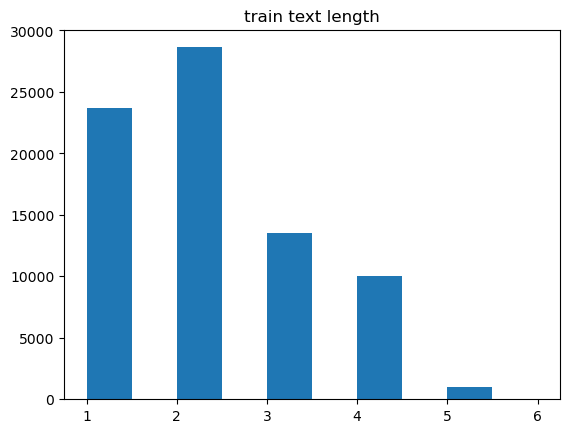

['1글자 : 23703개',
 '2글자 : 28631개',
 '3글자 : 13514개',
 '4글자 : 9988개',
 '5글자 : 1026개',
 '6글자 : 26개']

In [180]:
# train 데이터 글자수 파악
length_set = {len(x) for x in y_train['label'].unique()}
length_list = [len(x) for x in y_train['label']]

# 시각화
plt.hist(length_list)
plt.title('train text length')
plt.show()
[f'{i+1}글자 : {length_list.count(i+1)}개' for i in range(len(list(length_set)))]

## 등장 글자와 빈도수

In [213]:
# 등장하는 글자와 빈도수 파악

words_list = y_train['label'].to_list()
word_list = []

for i in words_list:
    for j in list(i):
        word_list.append(j)
    
word_unique = list(set(word_list))
word_dict = {key : word_list.count(key) for key in word_unique}
word_dict = sorted(word_dict.items(), key = lambda x:x[1], reverse=True)

# 빈도수 출력
# print(word_dict)
print('빈도수 높은 글자\n', word_dict[:15], '\n...\n', '빈도수 낮은 글자\n', word_dict[-20:])

빈도수 높은 글자
 [('다', 17863), ('하', 6150), ('지', 2602), ('이', 2233), ('기', 2159), ('리', 2110), ('가', 1636), ('사', 1519), ('어', 1436), ('자', 1414), ('대', 1372), ('아', 1344), ('적', 1338), ('시', 1209), ('되', 1105)] 
...
 빈도수 낮은 글자
 [('푿', 2), ('엾', 2), ('셨', 2), ('쳉', 2), ('껀', 2), ('꾼', 2), ('츱', 1), ('었', 1), ('삔', 1), ('뎬', 1), ('롑', 1), ('꽈', 1), ('딤', 1), ('빔', 1), ('쥘', 1), ('풉', 1), ('샹', 1), ('뚬', 1), ('봔', 1), ('쟉', 1)]


# 툴

## Overview

In [74]:
# 편하게 데이터 살펴볼 수 있는 데이터프레임
# -> 이후 클래스화

overview = pd.read_csv('train.csv')

overview['text_length'] = list_length

overview

class OverView:

,id,img_path,label,text_length
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색,3
1,TRAIN_00001,./train/TRAIN_00001.png,머,1
2,TRAIN_00002,./train/TRAIN_00002.png,차차,2
3,TRAIN_00003,./train/TRAIN_00003.png,써,1
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다,3
...,...,...,...,...
76883,TRAIN_76883,./train/TRAIN_76883.png,회,1
76884,TRAIN_76884,./train/TRAIN_76884.png,겪다,2
76885,TRAIN_76885,./train/TRAIN_76885.png,벨트,2
76886,TRAIN_76886,./train/TRAIN_76886.png,톼,1


## Show Image

In [729]:
num=6129

id = str('0'*(5-len(str(num))) + str(num))
path = ('./train/TRAIN_'+str(id)+'.png')

출력 이미지 :  06129
글자 :  뽀
글자 수 :  1


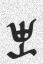

In [730]:
# 이미지를 보여주는 툴

def show_img(num):
    id = str('0'*(5-len(str(num))) + str(num))
    x = Image.open('./train/TRAIN_'+str(id)+'.png')
    print('출력 이미지 : ', id)
    print('글자 : ', overview['label'][int(id)])
    print('글자 수 : ', overview['text_length'][int(id)])
    return x

show_img(id)

출력 이미지 :  06129
글자 :  뽀
글자 수 :  1
(64, 43)


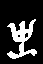

In [731]:
# 이미지 전처리
# (1) 흑백 전환
# (2) 노이즈 없애기
# (3) sharpenning

show_img(num)
x = Image.open(path).convert('L')
x = np.array(x)
print(x.shape)

x = abs(x - 255.)
x = x/x.max()
cal = np.sum(x)/np.count_nonzero(x)
weight = (1/cal)*0.9
x = x*x*100*weight
x = np.around(x, -2)*255/100

Image.fromarray(x.astype(np.uint8))

In [732]:
show_img(num)
x = Image.open(path).convert('L')
x = np.array(x)
print(x.shape)

x = abs(x - 255.)
x = x/255

print("max : ", x.max())
print("cal : ", np.sum(x)/np.count_nonzero(x))

출력 이미지 :  06129
글자 :  뽀
글자 수 :  1
(64, 43)
max :  0.9176470588235294
cal :  0.21270048529955826


|id|max|cal|weight|explain|
|--|--|--|--|--|
|24029|0.5215|0.0970|20|weight = cal / max x 100|
|14029|0.6745|0.1267|20|weight = cal / max x 100|
|31029|0.8431|0.1570|20|weight = cal / max x 100|
|1029|0.9058|0.1423|25|weight = cal / max x 150|
|3029|0.8078|0.1453|20|weight = |
|6029|0.8313|0.3886|3|weight = |
|7029|0.8431|0.2063|10|weight = |
|8029|0.7529|0.2363|10|
|9029|0.8431|0.2790|5|
|5029|0.6196|0.1230|22|
|15029|0.9686|0.3606|3|
|3329|0.8431|0.2370|20|






```python
show_img(num)
x = Image.open(path).convert('L')
x = np.array(x)
print(x.shape)

x = abs(x - 255.)
x = x/255

print("max : ", x.max())
print("cal : ", np.sum(x)/np.count_nonzero(x))
```







In [733]:
import pytesseract

In [734]:
img = Image.open(path)
pytesseract.image_to_string(img, lang='kor').replace('\n','')

''

SyntaxError: invalid syntax (1761970143.py, line 1)